## Importación

In [141]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime 
import math

from statsmodels.tsa.seasonal import seasonal_decompose #descomposición de una serie temporal
from statsmodels.tsa.stattools import adfuller 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error

In [142]:
df = pd.read_csv('data/DATOS_ANUALES_H7.csv', sep=';',encoding='latin1',decimal=",")

In [143]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Año     240 non-null    int64  
 1   Mes     240 non-null    int64  
 2   PEQ     240 non-null    float64
 3   PEQ_IT  240 non-null    float64
dtypes: float64(2), int64(2)
memory usage: 7.6 KB


## Cleaning

In [144]:
df['date'] = pd.to_datetime(
    dict(
        year=df['Año'], 
        month=df['Mes'], 
        day=1
    )
)

In [145]:
df = df[(df['date'] < "2022-02-01")]

In [146]:
ts=df.set_index('date')

<AxesSubplot:xlabel='date'>

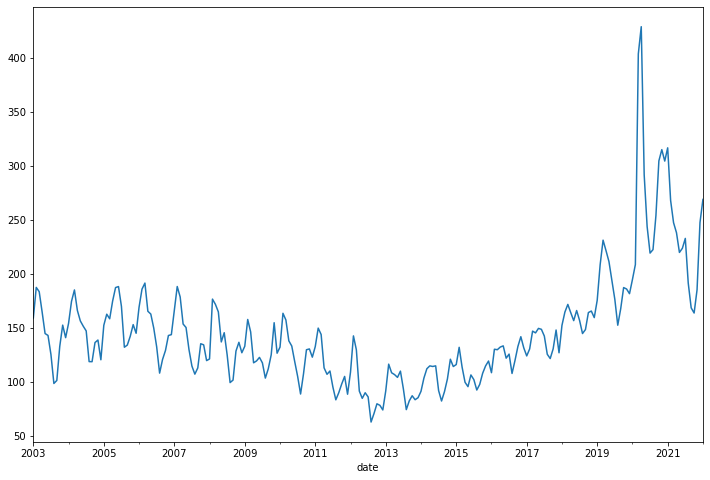

In [147]:
plt.rcParams['figure.figsize']=(12,8)
ts['PEQ_IT'].plot()

In [148]:
ts.drop(['Año','Mes','PEQ'], axis=1,inplace=True) #eliminamos la columnas que nos sobran

In [149]:
ts.head()

,PEQ_IT
date,
2003-01-01,159.12
2003-02-01,187.37
2003-03-01,183.42
2003-04-01,164.58
2003-05-01,144.67


In [139]:
## Formula para evaluar modelos

def get_error_percentage(real_it, predicted_it):
    #cuanto más cerca del 0 mejor
    print("get_error_percentage() method was called.")
    rmse = math.sqrt(mean_squared_error(real_it, 
    predicted_it))
    error_percentage = rmse / np.average(real_it)
    return error_percentage

## Analisis de seasonal decompose

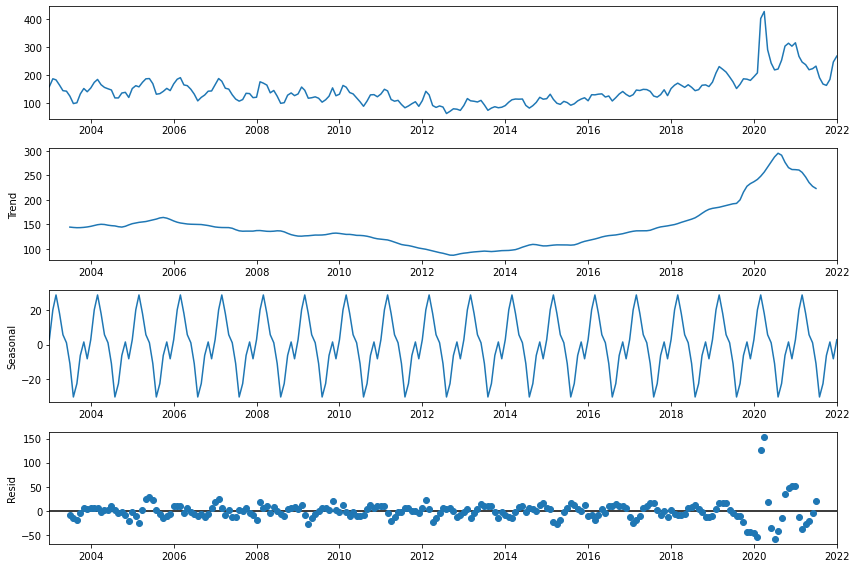

In [150]:
decomposition=seasonal_decompose(ts)
_=decomposition.plot()

### Accedemos por separado a los elementos de la descomposition

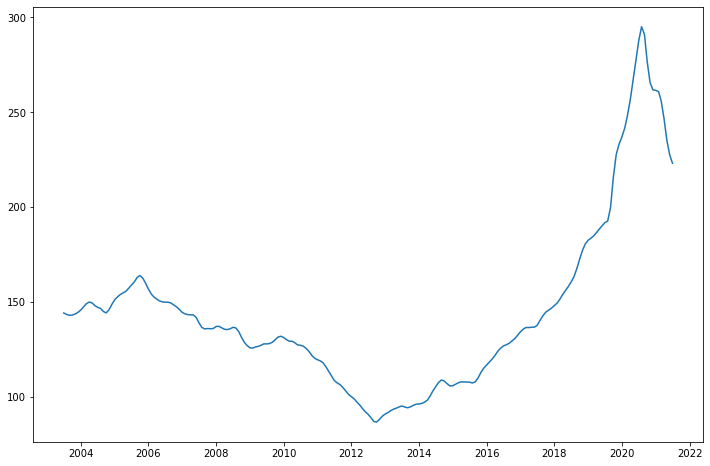

In [151]:
plt.plot(decomposition.trend) #obtengo la tendencia

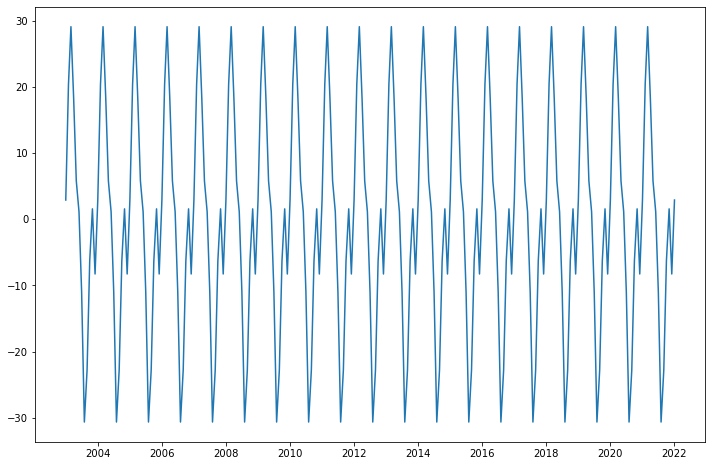

In [12]:
plt.plot(decomposition.seasonal) #obtengo la estacionalidad

<AxesSubplot:xlabel='date'>

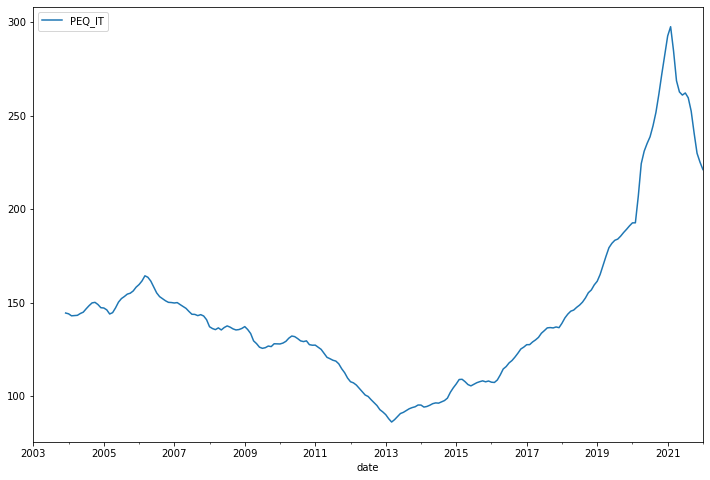

In [152]:
ts.rolling(12).mean().plot()
#el gráfico es muy parecido al que nos da la tendencia

## Analisis estacionariedad con adfuller

In [154]:
adfuller(ts)
'''
Intuimos que la ts no es estacionaria pq las medias ni las varianzas son constantes.
El resultado que nos interesa es el pvalue (0.576) > 0.05
La Ho es que la señal no es estacionaria, por tanto, la señal lo es (aceptamos la H0, por tanto, es estacionaria)
'''

'\nIntuimos que la ts no es estacionaria pq las medias ni las varianzas son constantes.\nEl resultado que nos interesa es el pvalue (0.576) > 0.05\nLa Ho es que la señal no es estacionaria, por tanto, la señal lo es (aceptamos la H0, por tanto, es estacionaria)\n'

<AxesSubplot:xlabel='date'>

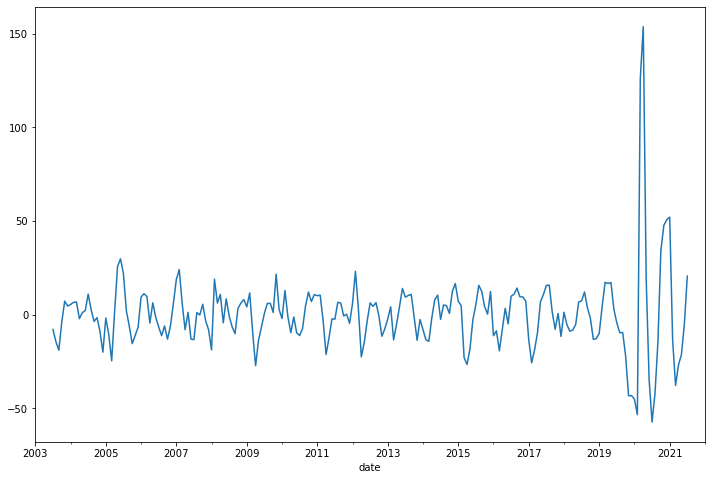

In [155]:
decomposition.resid.plot() #comprobar también si los residuos son estacionarios

In [156]:
adfuller(decomposition.resid.dropna())
 #señal estacionaria pq rechazo H0 => puedo usarla para predicciones

(-8.663856382632314,
 4.7423663451251755e-14,
 6,
 210,
 {'1%': -3.461878735881654,
  '5%': -2.875403665910809,
  '10%': -2.574159410430839},
 1653.9901952199045)

In [170]:
#la diferencia de una señal consigo misma
#adfuller(ts.diff().dropna()) #=> diferenciando una vez todavia el pvalues es > 0.05
adfuller(ts.diff(3).dropna()) #con una diferenciación de 3 ya estariamos en una señal estacionaria

(-3.3743110529856106,
 0.011866407726590714,
 12,
 213,
 {'1%': -3.461429147102264,
  '5%': -2.875206950587861,
  '10%': -2.5740544497344002},
 1882.0034463632062)

<AxesSubplot:xlabel='date'>

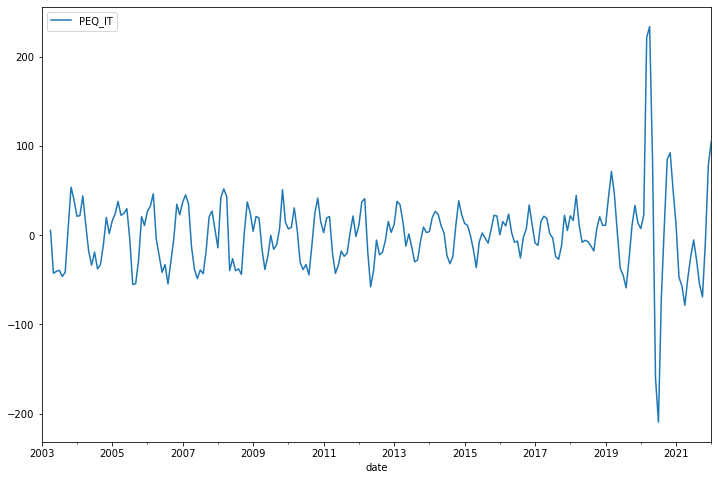

In [158]:
ts.diff(3).plot()

## Uso de funciones ACF/PACF

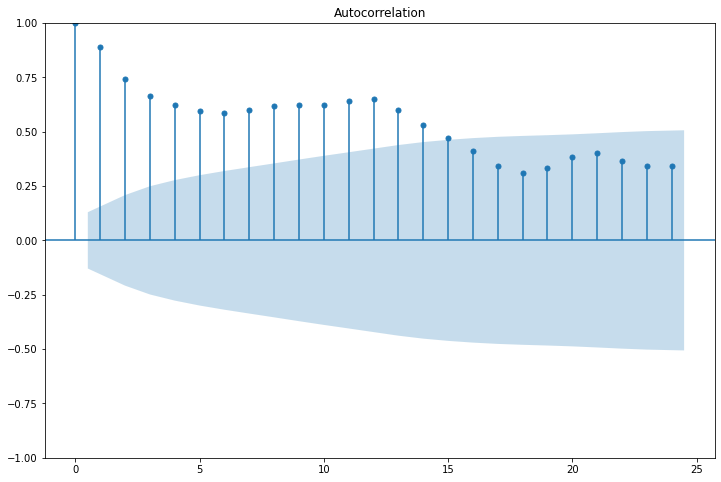

In [159]:
_=plot_acf(ts) #nos dice que hay una seasonality a los 12 meses

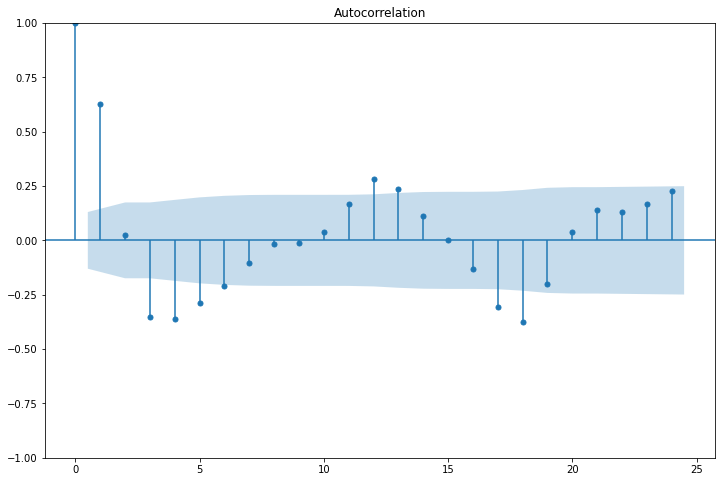

In [171]:
_=plot_acf(ts.diff(3).dropna()) #con la señal estacionaria nos dice que hay una seasonality a los 12 meses más clara

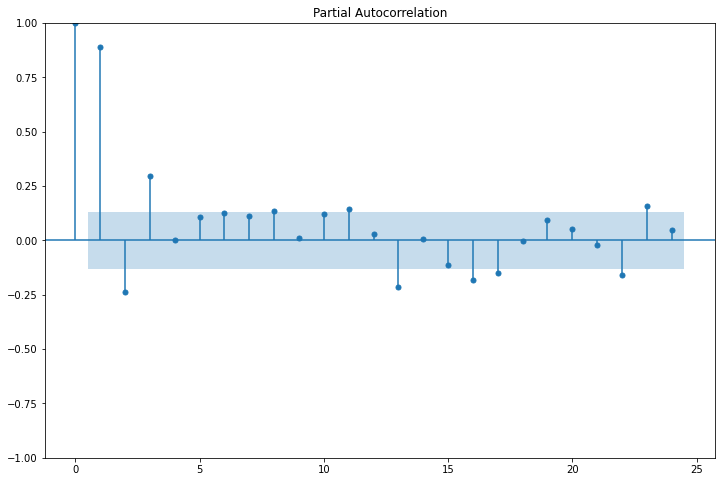

In [161]:
_=plot_pacf(ts, method='ywm') #dibujamos la autocorrelación parcial de mi serie temporal
#nos dice que con uno, dos o tres terminos regresivos tendriamos un buen modelo estacionario

## Modelación con ARIMA

In [195]:
#opcion 1
params = (2,1,2) #definimos 2 terminos regresivo, 3 diferenciacion, 2 de moving average
sparams = (2,1,2,12) #los mismos de arriba más la indicación de 12 meses
#freq MS quiere decir frecuencia mensual

model = SARIMAX(ts, 
                order=params,
                seasonal_order=sparams, 
                freq='MS',
                )

C:\Users\carlo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [196]:
results=model.fit(maxiter=100)

In [197]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                             PEQ_IT   No. Observations:                  229
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 12)   Log Likelihood                -946.091
Date:                            Thu, 03 Mar 2022   AIC                           1910.181
Time:                                    20:57:52   BIC                           1940.559
Sample:                                01-01-2003   HQIC                          1922.454
                                     - 01-01-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6780      0.137      4.932      0.000       0.409       0.947
ar.L2         -0.2667      0.159     -1.674      0.094      -0.579       0.046
ma.L1         -0.5687      0.158     -3.592      0.000      -0.879      -0.258
ma.L2         -0.2047      0.166     -1.233      0.218      -0.530       0.121
ar.S.L12      -0.7190      1.224     -0.588      0.557      -3.117       1.679
ar.S.L24      -0.2516      0.309     -0.815      0.415      -0.856       0.353
ma.S.L12      -0.1080      1.239     -0.087      0.931      -2.537       2.321
ma.S.L24      -0.2491      0.875     -0.285      0.776      -1.964       1.465
sigma2       355.1296     18.559     19.135      0.000     318.755     391.504
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             18197.34
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               5.40   Skew:                             4.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        47.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:>

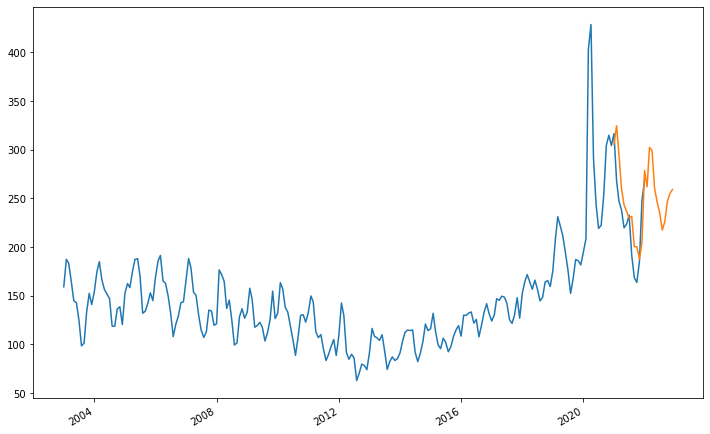

In [198]:
#intetamos hacer una prediccion de los datos del último año a partir de nuestro modelo
plt.plot(ts)
results.get_prediction(start='2021-01-01',end='2022-12-01').predicted_mean.plot()

In [199]:
#Evaluamos modelo:
y_pred=results.get_prediction(start='2003-01-01',end='2022-01-01').predicted_mean
porc_error_ARIMA_212=get_error_percentage(ts,y_pred)
porc_error_ARIMA_212


get_error_percentage() method was called.


0.15136293707240728

## Modelación con autoarima

In [200]:
model=auto_arima(ts, trace=True) 

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2032.109, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2086.163, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2077.840, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2064.886, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2084.260, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2031.969, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2054.483, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2062.420, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2032.070, Time=0.17 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=2032.409, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2036.824, Time=0.15 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2029.993, Time=0.31 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=2034.660, Time=0.38 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=2034.774, Time=0.41 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept

In [206]:
help(model)

Help on ARIMA in module pmdarima.arima.arima object:

class ARIMA(pmdarima.base.BaseARIMA)
 |  ARIMA(order, seasonal_order=(0, 0, 0, 0), start_params=None, method='lbfgs', maxiter=50, suppress_warnings=False, out_of_sample_size=0, scoring='mse', scoring_args=None, trend=None, with_intercept=True, **sarimax_kwargs)
 |  
 |  An ARIMA estimator.
 |  
 |  An ARIMA, or autoregressive integrated moving average, is a
 |  generalization of an autoregressive moving average (ARMA) and is fitted to
 |  time-series data in an effort to forecast future points. ARIMA models can
 |  be especially efficacious in cases where data shows evidence of
 |  non-stationarity.
 |  
 |  The "AR" part of ARIMA indicates that the evolving variable of interest is
 |  regressed on its own lagged (i.e., prior observed) values. The "MA" part
 |  indicates that the regression error is actually a linear combination of
 |  error terms whose values occurred contemporaneously and at various times
 |  in the past. The "I" 

In [201]:
model.predict(n_periods=12)

array([262.87574293, 247.81306049, 216.04575233, 184.29737693,
       177.05962386, 186.09454317, 189.45861099, 192.46858046,
       211.03454501, 232.82023468, 235.24892454, 225.88081532])

<AxesSubplot:>

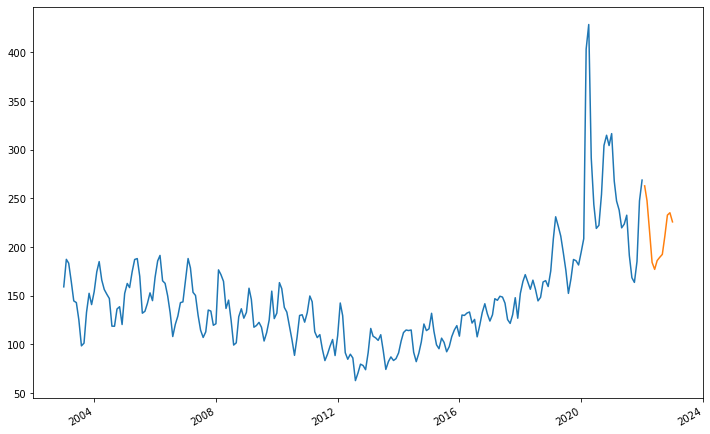

In [202]:
pred=model.predict(n_periods=12)
plt.plot(ts)
pd.Series(pred,
          index=pd.date_range(start='2022-02-01', 
                              end='2023-01-01', 
                              freq='MS')).plot()
results=model.fit(maxiter=100)

In [207]:
params = (4,1,5) #definimos 2 terminos regresivo, 3 diferenciacion, 2 de moving average
sparams = (4,1,5,12) #los mismos de arriba más la indicación de 12 meses
#freq MS quiere decir frecuencia mensual

model = SARIMAX(ts, 
                order=params,
                seasonal_order=sparams, 
                freq='MS',
                )

results=model.fit(maxiter=100)

C:\Users\carlo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\carlo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\carlo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\carlo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\carlo\anaconda3\lib\site-packages\statsmodels

In [208]:
#Evaluamos modelo:
y_pred=results.get_prediction(start='2003-01-01',end='2022-01-01').predicted_mean
porc_error_ARIMA_415=get_error_percentage(ts,y_pred)
porc_error_ARIMA_415

get_error_percentage() method was called.


0.14800310601751593

## Modelación con Fbprophet

In [209]:
model=Prophet() #instanciamos prophet
#el df tiene que tener ds como nombre de fecha e y con la ts

In [210]:
ts.head()

,PEQ_IT
date,
2003-01-01,159.12
2003-02-01,187.37
2003-03-01,183.42
2003-04-01,164.58
2003-05-01,144.67


In [211]:
#transformación requerida
df=ts.reset_index().rename(columns={'date':'ds','PEQ_IT':'y'}) 
#reset_index para recuperar la fecha como columna

In [212]:
model.fit(df) #nos dice que dentro de todas las estacionalidades no encuentra ni semanal ni diaria

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [213]:
model.predict(df) 

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2003-01-01,162.668507,132.217221,197.653821,162.668507,162.668507,0.390821,0.390821,0.390821,0.390821,0.390821,0.390821,0.0,0.0,0.0,163.059329
1,2003-02-01,162.227476,152.234504,218.338868,162.227476,162.227476,22.720832,22.720832,22.720832,22.720832,22.720832,22.720832,0.0,0.0,0.0,184.948307
2,2003-03-01,161.829124,152.718119,217.222012,161.829124,161.829124,24.206370,24.206370,24.206370,24.206370,24.206370,24.206370,0.0,0.0,0.0,186.035494
3,2003-04-01,161.388093,133.866347,203.779980,161.388093,161.388093,7.000586,7.000586,7.000586,7.000586,7.000586,7.000586,0.0,0.0,0.0,168.388679
4,2003-05-01,160.961288,131.267789,200.499316,160.961288,160.961288,5.751031,5.751031,5.751031,5.751031,5.751031,5.751031,0.0,0.0,0.0,166.712319
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,2021-09-01,256.255837,197.989064,261.725612,256.255837,256.255837,-27.485228,-27.485228,-27.485228,-27.485228,-27.485228,-27.485228,0.0,0.0,0.0,228.770609
225,2021-10-01,258.279986,214.748627,278.815212,258.279986,258.279986,-11.871076,-11.871076,-11.871076,-11.871076,-11.871076,-11.871076,0.0,0.0,0.0,246.408910
226,2021-11-01,260.371607,224.946339,292.746420,260.371607,260.371607,-3.233702,-3.233702,-3.233702,-3.233702,-3.233702,-3.233702,0.0,0.0,0.0,257.137905
227,2021-12-01,262.395756,219.624093,286.517802,262.395756,262.395756,-9.569175,-9.569175,-9.569175,-9.569175,-9.569175,-9.569175,0.0,0.0,0.0,252.826581


In [214]:
yhat=model.predict(df).yhat

In [215]:
y_pred=pd.DataFrame({'y':yhat,
             'ds':pd.date_range(start='2003-01-01',
                                  end='2022-01-01',
                                  freq='MS')}).set_index('ds')

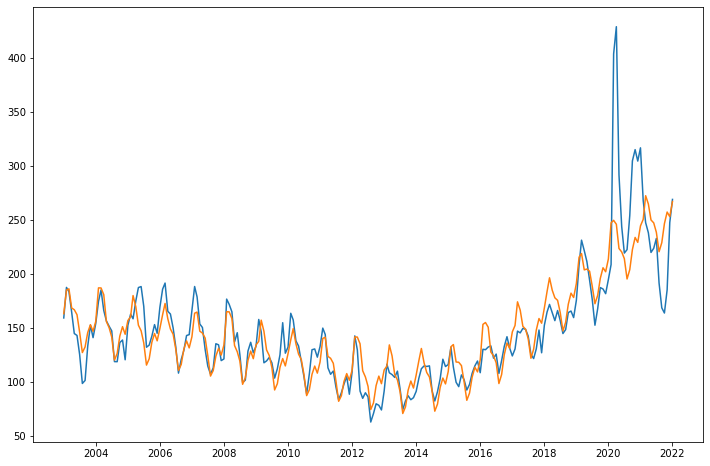

In [216]:
plt.plot(ts)
plt.plot(y_pred)

In [217]:
#Evaluamos modelo:
porc_error_PROPHET_SIMPLE=get_error_percentage(ts,y_pred)
porc_error_PROPHET_SIMPLE

get_error_percentage() method was called.


0.17704684800210965

In [38]:
#prediccion a futuro => creamos dataframe con  las fechas que queremos
ds= pd.DataFrame({'ds':pd.date_range(start='2021-01-01',
                                  end='2022-12-01',
                                  freq='MS')})

In [39]:
yhat=model.predict(ds).yhat

In [40]:
ds['y_pred']=yhat
ds.head()

,ds,y_pred
0,2021-01-01,244.305446
1,2021-02-01,250.321823
2,2021-03-01,272.236177
3,2021-04-01,264.570281
4,2021-05-01,249.796564


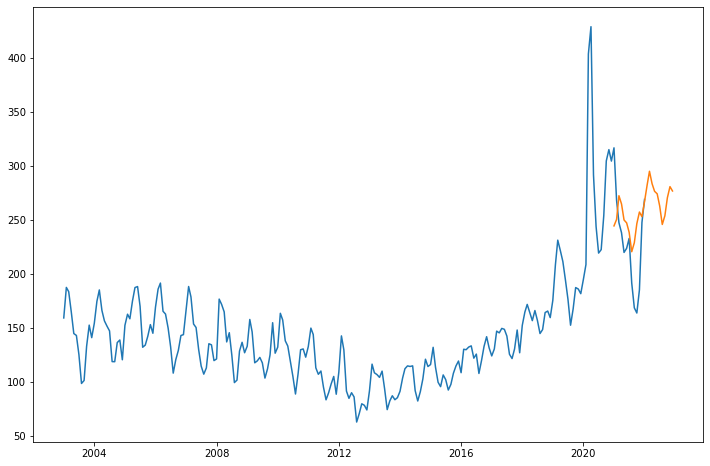

In [41]:
plt.plot(ts)
plt.plot(ds.set_index('ds'))

## Modelación con Fbprophet con variable exógena

In [218]:
#Entrenamos nuevo modelo con variable exógena (PEQ)

df2 = pd.read_csv('data/DATOS_ANUALES_H7.csv', sep=';',encoding='latin1',decimal=",")

df2['date'] = pd.to_datetime(
    dict(
        year=df2['Año'], 
        month=df2['Mes'], 
        day=1
    )
)

df2 = df2[(df2['date'] < "2022-02-01")]
ts2=df2.set_index('date')

ts2.drop(['Año','Mes','PEQ_IT'], axis=1,inplace=True)


df3=ts2.reset_index().rename(columns={'date':'ds','PEQ':'y'}) 
df3.head()

,ds,y
0,2003-01-01,2419.55
1,2003-02-01,2399.37
2,2003-03-01,2410.70
3,2003-04-01,2421.21
4,2003-05-01,2388.48


In [219]:
#hacemos la previsión de lo histórico

model2=Prophet()

model2.fit(df3)
yhat2=model2.predict(df3).yhat
y_pred2=pd.DataFrame({'y':yhat2,
             'ds':pd.date_range(start='2003-01-01',
                                  end='2022-01-01',
                                  freq='MS')}).set_index('ds')

ts2=ts2.reset_index().rename(columns={'date':'ds','PEQ':'y'}).set_index('ds')


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


' El modelo prevé que la plantilla continuará subiendo al mismo ritmo'

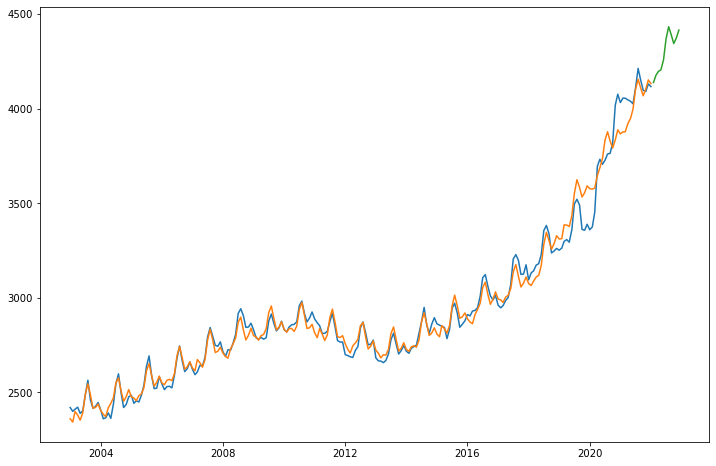

In [220]:
ds2= pd.DataFrame({'ds':pd.date_range(start='2022-02-01',
                                  end='2022-12-01',
                                  freq='MS')})
yhat3=model2.predict(ds2).yhat

ds2['y_pred']=yhat3

plt.plot(ts2) #real
plt.plot(y_pred2) #previsión pasada
plt.plot(ds2.set_index('ds')) #previsión futura

''' El modelo prevé que la plantilla continuará subiendo al mismo ritmo'''

In [221]:
#Instancio nuevo modelo, añado regressor PEQ y lo vuelvo a entrenar.
d_df = df2.rename(columns={'date':'ds','PEQ_IT':'y'}).drop(['Año','Mes'],axis=1)

m=Prophet()
m.add_regressor('PEQ')
m.fit(d_df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [222]:
#hacemos la previsión de lo histórico

yhat=m.predict(d_df).yhat

y_pred=pd.DataFrame({'y':yhat,
             'ds':pd.date_range(start='2003-01-01',
                                  end='2022-01-01',
                                  freq='MS')}).set_index('ds')


In [223]:
#Evaluamos modelo:
porc_error_PROPHET_1REGRESSOR=get_error_percentage(ts,y_pred)
porc_error_PROPHET_1REGRESSOR

get_error_percentage() method was called.


0.17534626633393147

In [126]:
#Creamos el df futuro (de 11 meses de 2022) con los datos de ds2:
future=ds2.rename(columns={'y_pred':'PEQ'})

#hacemos la previsión de lo futuro
forecast=m.predict(future).yhat
y_forecast=pd.DataFrame({'y':forecast,
             'ds':pd.date_range(start='2022-02-01',
                                  end='2022-12-01',
                                  freq='MS')}).set_index('ds')

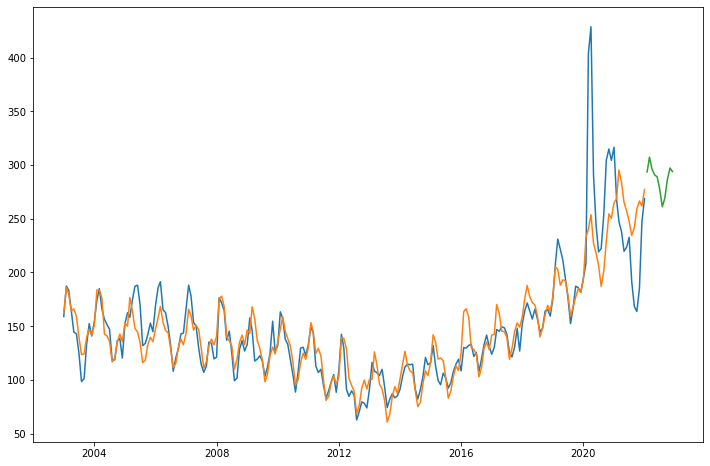

In [127]:
#Dibujamos el real + las previsiones pasadas y futuras
plt.plot(ts)
plt.plot(y_pred)
plt.plot(y_forecast)

## Escoger modelo en base a su score

In [234]:
scores= [porc_error_ARIMA_212,porc_error_ARIMA_415,porc_error_PROPHET_SIMPLE,porc_error_PROPHET_1REGRESSOR]
models=['ARIMA_212','ARIMA_415','PROPHET_SIMPLE','PROPHET_1REGRESSOR']
zipped=list(zip(models,scores))

ranking_modelos=pd.DataFrame(zipped,columns={'error_percentage','model'}).sort_values(by='error_percentage')

In [235]:
ranking_modelos

,model,error_percentage
1,ARIMA_415,0.148003
0,ARIMA_212,0.151363
3,PROPHET_1REGRESSOR,0.175346
2,PROPHET_SIMPLE,0.177047


C:\Users\carlo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\carlo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\carlo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\carlo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\carlo\anaconda3\lib\site-packages\statsmodels

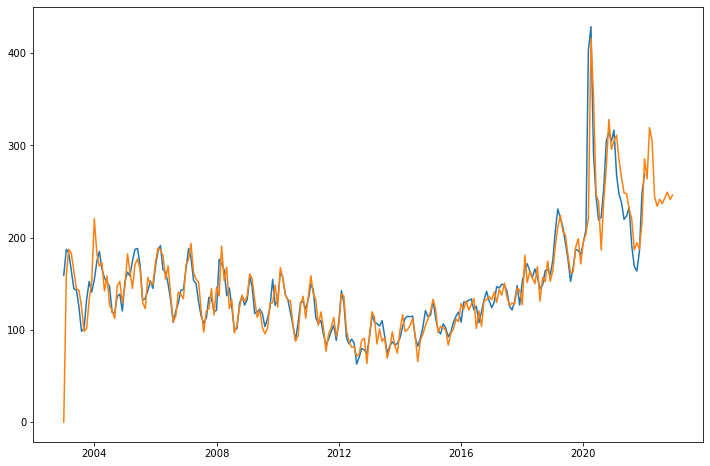

In [236]:
params = (4,1,5) #definimos 2 terminos regresivo, 3 diferenciacion, 2 de moving average
sparams = (4,1,5,12) #los mismos de arriba más la indicación de 12 meses
#freq MS quiere decir frecuencia mensual

model = SARIMAX(ts, 
                order=params,
                seasonal_order=sparams, 
                freq='MS',
                )

results_415=model.fit(maxiter=100)

y_pred=results.get_prediction(start='2003-01-01',end='2022-12-01').predicted_mean

plt.plot(ts)
plt.plot(y_pred)

In [239]:
y_pred.tail(12)

2022-01-01    285.419196
2022-02-01    263.535574
2022-03-01    319.283976
2022-04-01    304.930304
2022-05-01    244.463216
2022-06-01    233.892186
2022-07-01    241.615821
2022-08-01    236.732113
2022-09-01    243.212429
2022-10-01    249.321770
2022-11-01    241.274003
2022-12-01    245.998294
Freq: MS, Name: predicted_mean, dtype: float64